In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time


In [2]:
print(np.pi)

3.141592653589793


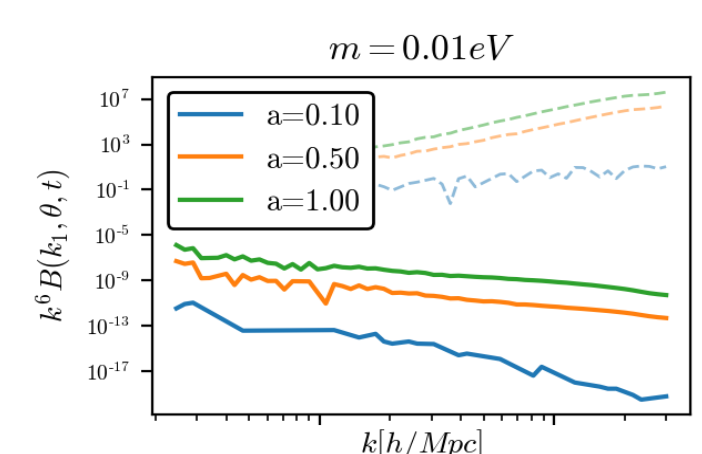
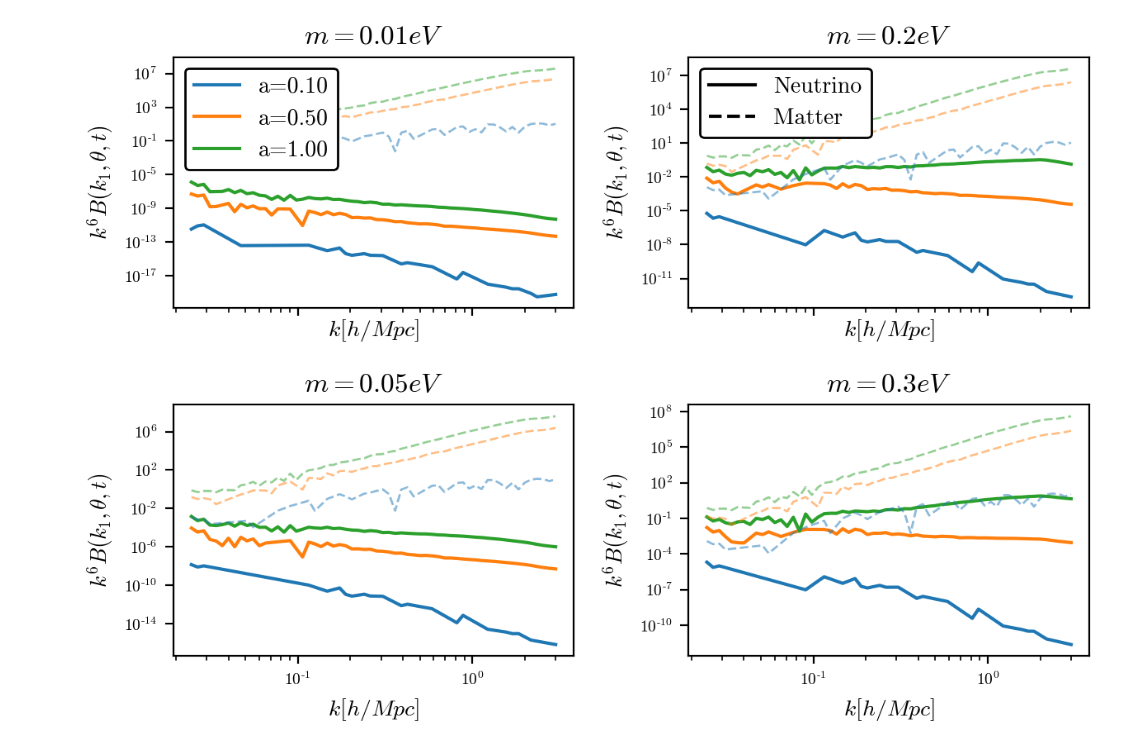

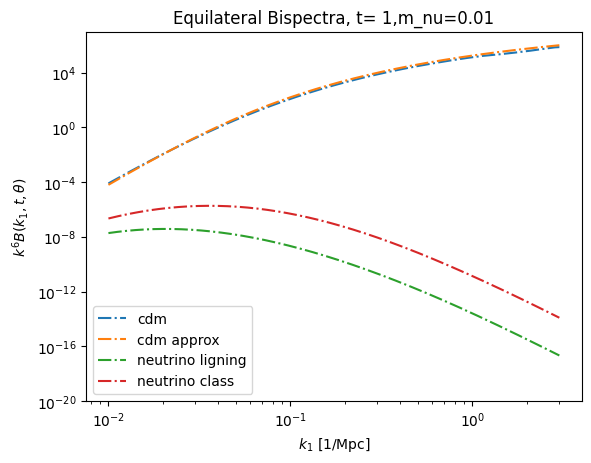

In [10]:
def TEST(kvec=[1],k_ind=0,z=800,
         mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T_0 / a / mv
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    delta_test   = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_neu    = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    neu_list     = np.empty(len(kvec))
    neu_sim_list = np.empty(len(kvec))
    neu_class_list = np.empty(len(kvec))
    # her genere 
    for kind,k in enumerate(kvec): 
        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class,kind=interpolation_type)
        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        
        t0 = tid_class[-1]
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100) 
        
        def Dfunc(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta#0/(a0) * a# - (c*k)**2 * delta/a**4 

            return [d_delta,d2_delta]
        
        def f2(t):
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 3 * cs(a) * k * t0 * np.sqrt(a)        
            return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 

        delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [delta_interp(T0),delta_diff(T0,0.1)]
        sol = scipy.integrate.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        
        
        delta_M[kind] = sol.y[0][-1]
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
        delta_neu[kind] = delta_neutrino_class[-1]
        neu_list[kind] = f2(t0)
    
        c = cs(1)
        def D1func(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta0/(a0) * a - (c*k)**2 * delta/a**2#4 

            return [d_delta,d2_delta]
        
        delta_diff = lambda t,h: (neu_tid(t+h)-neu_tid(t))/h
        start0 = [neu_tid(T0),delta_diff(T0,0.1)]
        sol = scipy.integrate.solve_ivp(D1func, t_span = tspan, y0 = start0)
        
        neu_class_list[kind] = delta_neutrino_class[-1]#
        neu_sim_list[kind] = sol.y[0][-1]
     
    diff_neu = lambda t,h: (neu_tid(t+h)-neu_tid(t))/h
    
    def f2(t):
        C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        dcdm = delta0/a0        
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
 
    delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
    p_approx = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    delta_neu_interp = scipy.interpolate.interp1d(kvec,neu_list)
    p_neu = lambda k: 2*np.pi**2 * delta_neu_interp(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    delta_neu_sim_interp = scipy.interpolate.interp1d(kvec,neu_sim_list)
    p_neu_sim = lambda k: 2*np.pi**2 * delta_neu_sim_interp(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    kvec = np.array(kvec)
    logkvec = np.log10(kvec)
    def p2(delta, k):
        return 2 * np.pi ** 2 * delta**2 *  prim_interp(k) * h**3 *  k**(-3)
    
    loglog_ptest_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_test, kvec)), kind=interpolation_type)
    def p_TEST(k):
        return 10** loglog_ptest_interp(np.log10(k))
    
    p_approx_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_approx, kvec)), kind=interpolation_type)
    def p_approx(k):
        return 10** p_approx_interp(np.log10(k))
    
    p_M_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_M, kvec)), kind=interpolation_type)
    def p_sim(k):
        return 10** p_M_interp(np.log10(k))
    
    p_neu_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_neu, kvec)), kind=interpolation_type)
    def p_neu_sim(k):
        return 10** p_neu_interp(np.log10(k))
    
    p_neu_lig_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(neu_list, kvec)), kind=interpolation_type)
    def p_neu_lig(k):
        return 10** p_neu_lig_interp(np.log10(k))
    
    p_neu_class_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(neu_class_list, kvec)), kind=interpolation_type)
    def p_neu_class(k):
        return 10** p_neu_class_interp(np.log10(k))
     
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
            
    def Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res        
    
    def Test_Bispektrum(k1,t,theta,p):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res        
    
    def Neu_Sim_Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p_neu_sim(k1)*p_neu_sim(k2)*K(k1,t,theta) +2*p_neu_sim(k3)*p_neu_sim(k1)*K(k3,t3,theta3) +2*p_neu_sim(k2)*p_neu_sim(k3)*K(k2,t2,theta2))
        return res
            
    def Neu_class_Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p_neu_class(k1)*p_neu_class(k2)*K(k1,t,theta) +2*p_neu_class(k3)*p_neu_class(k1)*K(k3,t3,theta3) +2*p_neu_class(k2)*p_neu_class(k3)*K(k2,t2,theta2))
        return res
        
    def Neu_lig_Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p_neu_lig(k1)*p_neu_lig(k2)*K(k1,t,theta) +2*p_neu_lig(k3)*p_neu_lig(k1)*K(k3,t3,theta3) +2*p_neu_lig(k2)*p_neu_lig(k3)*K(k2,t2,theta2))
        return res
    
    
    plt.figure(13241324123123)
    theta = np.linspace(0,np.pi/2,100)
    k1 = np.logspace(-2,np.log10(3),500) #/ h
    plt.title("Equilateral Bispectra, t= 1,m_nu=%s"%mv_test)
    
    plt.loglog(k1,k1**6*Test_Bispektrum(k1,1,np.pi/3,p),"-.",label="cdm")
    plt.loglog(k1,k1**6*Test_Bispektrum(k1,1,np.pi/3,p_approx),"-.",label="cdm approx")
    plt.loglog(k1,k1**6*Test_Bispektrum(k1,1,np.pi/3,p_neu_lig),"-.",label="neutrino ligning")
    plt.loglog(k1,k1**6*Test_Bispektrum(k1,1,np.pi/3,p_neu_class),"-.",label="neutrino class")
    #plt.loglog(k1,k1**6*Test_Bispektrum(k1,1,np.pi/3,p_neu_sim),"-.",label="neutrino simulering")
    plt.xlabel("$k_1$ [1/Mpc]")
    plt.ylabel("$k^6 B(k_1,t,\\theta)$")
    plt.legend()
    plt.ylim(1e-20,1e7)

kvec1 = list(np.logspace(-4,1,10)) 
TEST(kvec = kvec1,mv_test=0.01)

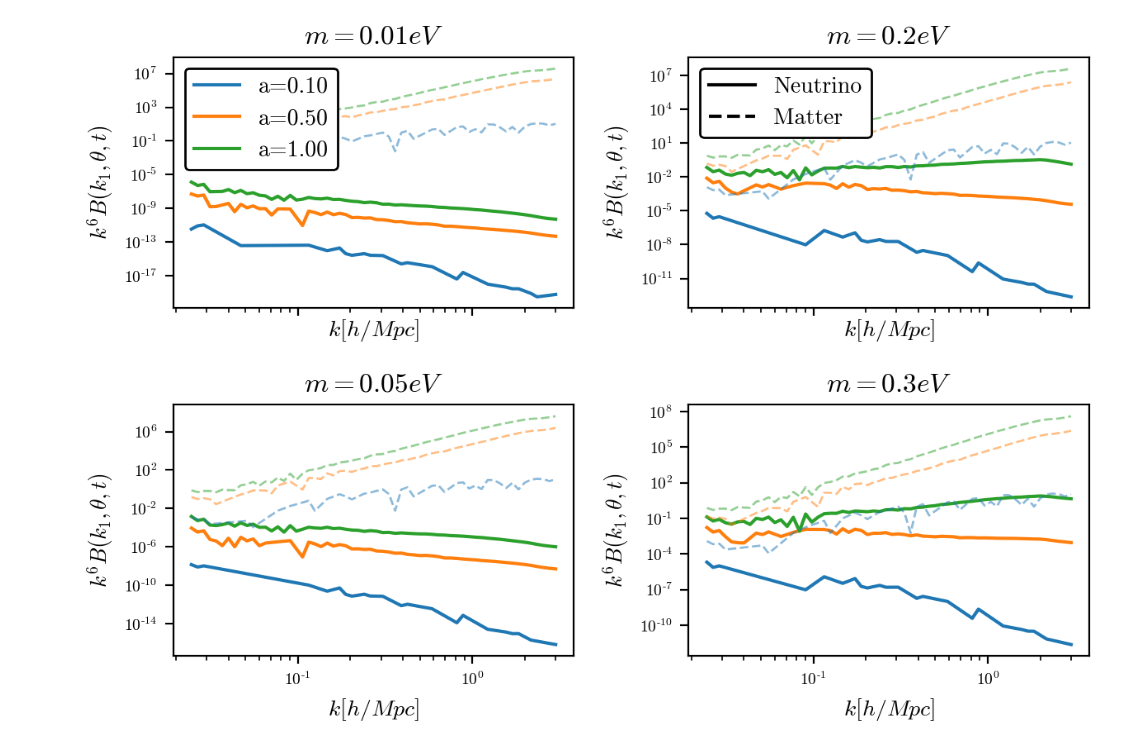
